In [1]:
import os
import pdb 
import numpy as np
from einops import rearrange
from vima.utils import *
from vima_bench import *
from vima_bench import make,PARTITION_TO_SPECS
from vima import create_policy_from_ckpt
os.environ["TOKENIZERS_PARALLELISM"] = "true"
from glob import glob 
import pickle as pkl 
from PIL import Image 
from vima.extra_utils import prepare_prompt,prepare_obs
import torch 
from torch.optim import Adam 
from vima.policy.vima_policy  import VIMAPolicy 
from pathlib import Path 
from torch.utils.tensorboard import SummaryWriter
from vima.trajectory.trajectory_dataset import TrajectoryLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tokenizers import AddedToken
from tokenizers import Tokenizer



/home/rlcorrea/.conda/envs/my_vima/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May 20 2022 19:45:31


[INFO] 17 tasks loaded


In [18]:
def viz_obs(obs_d,ax=None): 
    img_slice = np.moveaxis(obs_d['rgb']['front'],[0],[2])
    if ax: 
        ax.imshow(img_slice)
        ax.axis('off')
    else: 
        plt.imshow(img_slice)
        plt.axis('off')

In [7]:
device = 'cuda:0'
vima_config = {'embed_dim': 256, 'xf_n_layers': 1, 'sattn_n_heads': 8, 'xattn_n_heads': 8}
policy =  VIMAPolicy(**vima_config) 
weight_path = "/home/rlcorrea/CSE574_project_vima/model_weights/2M.ckpt"
ckpt = torch.load(weight_path,map_location=device) 
#load the pretrained model except for the policy agents weight. The action prediction is handeled by the cross attention_gpt 
policy.load_state_dict({k.replace('policy.',""):v for k,v in ckpt['state_dict'].items() if 'xattn_gpt' not in k},strict=False)
policy = policy.train()

In [8]:
for n,e in policy.named_parameters(): 
        e.requires_grad = False 
for n,e in policy.xattn_gpt.named_parameters(): 
        e.requires_grad = True 
policy = policy.to(device)

In [9]:
env = make('rearrange',modalities=['segm','rgb'],task_kwargs=PARTITION_TO_SPECS["test"]['placement_generalization']['rearrange'],seed=42,render_prompt=False,display_debug_window=False,hide_arm_rgb=False,record_gui=False)
obs = env.reset() 
meta_info = env.meta_info 
meta_info = env.meta_info 
prompt = env.prompt 
prompt_assets = env.prompt_assets

/home/rlcorrea/.conda/envs/my_vima/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [10]:
obs.keys()

dict_keys(['segm', 'rgb', 'ee'])

In [11]:
done = False
infer_cache = {} 
infer_cache['obs_tokens'] = [] 
infer_cache['obs_masks'] = [] 
infer_cache['action_tokens'] =[] 
obs_list =list()
obs_list.append(obs)
for num_steps in range(20): 
    if num_steps ==0: 
         prompt_token_type, word_batch, image_batch = prepare_prompt(
                        prompt=prompt, prompt_assets=prompt_assets, views=["front", "top"]
                    )
    image_batch = image_batch.to_torch_tensor(device=device)
    word_batch = word_batch.to(device) 
    prompt_tokens, prompt_masks = policy.forward_prompt_assembly(
                (prompt_token_type, word_batch, image_batch)
                )
    obs = any_to_datadict(obs)
    obs['ee']= np.array(obs['ee'])
    input_d = {
    'prompt_tokens':prompt_tokens,
    'prompt_masks':prompt_masks,
    'obs':obs}
    out_actions = simple_forward(policy,input_d,infer_cache,meta_info,device)
    obs, rew, done, info = env.step(out_actions)
    obs_list.append(obs)
    if done: 
        break 


text argument:/home/rlcorrea/CSE574_project_vima/VIMABench/vima_bench/tasks/assets
int args: [text argument:/home/rlcorrea/CSE574_project_vima/VIMABench/vima_bench/tasks/assets
int args: [

In [13]:
len(obs_list)

21

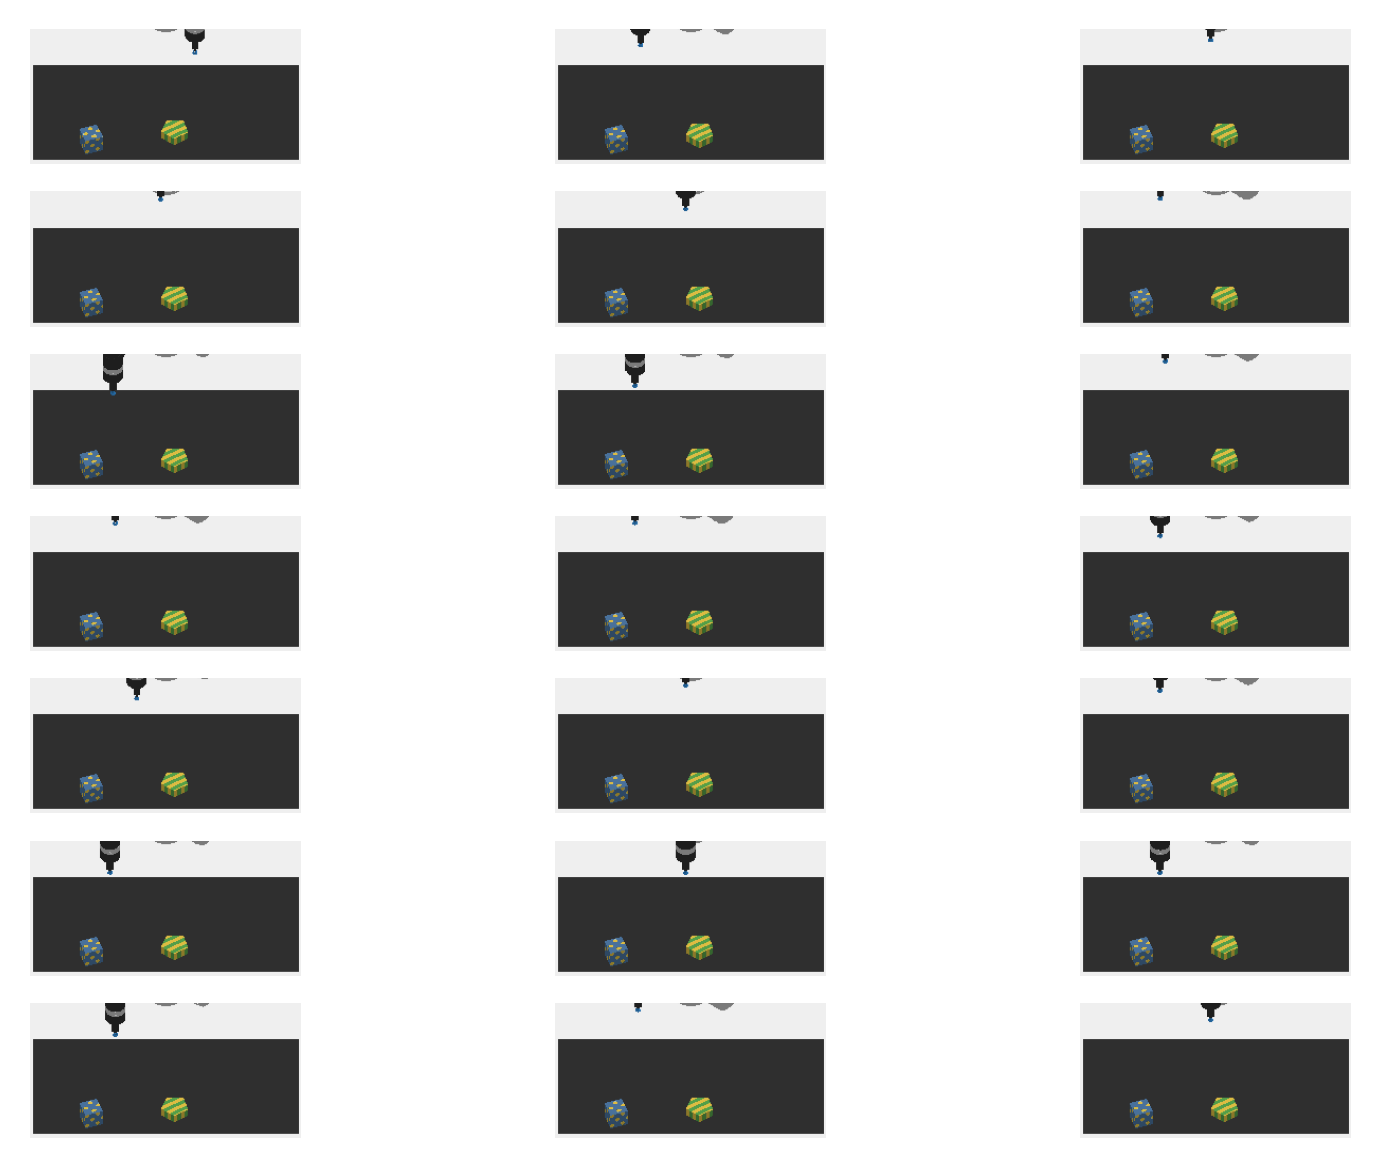

In [19]:
fig,ax = plt.subplots(7,3,dpi=300)
ax = ax.flatten() 
for i,axis in enumerate(ax): 
    viz_obs(obs_list[i],axis)

In [24]:
obs_list[0]['rgb']['front'].shape

(3, 128, 256)

In [37]:
#def calculate_distances(obs_list): 
grey_screen = .vstack([e['rgb']['front'].flatten().reshape((1,-1)) for e in  obs_list])


In [39]:
grey_screen.shape

(21, 98304)

In [42]:
torch.cdist(query_vec,grey_screen)

TypeError: cdist(): argument 'x1' (position 1) must be Tensor, not numpy.ndarray

In [41]:
query_vec = grey_screen[-1]


In [ ]:
from scipy.

In [5]:
def action_to_device(action,device= None): 
    for e in action.keys(): 
        action[e] = action[e].to(device)

In [6]:
def simple_forward(policy,inputs,inference_cache,meta_info,device):
        #get the current observation  and preprocess it 
        obs= inputs['obs'] 
        c_step = len(inference_cache['obs_tokens'])
        prompt_tokens = inputs['prompt_tokens']
        prompt_masks = inputs['prompt_masks']
        obs = inputs['obs']
        obs = add_batch_dim(obs)
        obs = prepare_obs(obs=obs, rgb_dict=None, meta=meta_info).to_torch_tensor(
            device=device
            )
        ################# BEGIN COMPLICATED FORWARD STEP ###########
        obs_token_this_step, obs_mask_this_step = policy.forward_obs_token(obs)
        obs_token_this_step = obs_token_this_step.squeeze(0)
        obs_mask_this_step = obs_mask_this_step.squeeze(0)
        inference_cache["obs_tokens"].append(obs_token_this_step[0])
        inference_cache["obs_masks"].append(obs_mask_this_step[0])
        max_objs = max(x.shape[0] for x in inference_cache["obs_tokens"])
        obs_tokens_to_forward, obs_masks_to_forward = [], []
        obs_tokens_this_env, obs_masks_this_env = [], []
        for idx in range(len(inference_cache["obs_tokens"])):
            obs_this_env_this_step = inference_cache["obs_tokens"][idx]
            obs_mask_this_env_this_step = inference_cache["obs_masks"][idx]
            required_pad = max_objs - obs_this_env_this_step.shape[0]
            obs_tokens_this_env.append(
                any_concat(
                    [
                        obs_this_env_this_step,
                        torch.zeros(
                            required_pad,
                            obs_this_env_this_step.shape[1],
                            device=device,
                            dtype=obs_this_env_this_step.dtype,
                        ),
                    ],
                    dim=0,
                )
            )
            obs_masks_this_env.append(
                any_concat(
                    [
                        obs_mask_this_env_this_step,
                        torch.zeros(
                            required_pad,
                            device=device,
                            dtype=obs_mask_this_env_this_step.dtype,
                        ),
                    ],
                    dim=0,
                )
            )
        #stack the list 
        obs_tokens_to_forward.append(any_stack(obs_tokens_this_env, dim=0))
        obs_masks_to_forward.append(any_stack(obs_masks_this_env, dim=0))
        obs_tokens_to_forward = any_stack(obs_tokens_to_forward, dim=0)
        obs_masks_to_forward = any_stack(obs_masks_to_forward, dim=0)
        obs_tokens_to_forward = obs_tokens_to_forward.transpose(0, 1)
        obs_masks_to_forward = obs_masks_to_forward.transpose(0, 1)
        if c_step ==0: 
            action_tokens_to_forward = None
        else:
            action_tokens_to_forward = any_stack(
                    [any_stack(inference_cache["action_tokens"], dim=0)],
                    dim=0,
                )
            action_tokens_to_forward = action_tokens_to_forward.transpose(0, 1)
        ### END complicated forward step 
        #the models actions are provided as a single embedding 
        predicted_action_tokens = policy.forward(
            obs_token=obs_tokens_to_forward,
            action_token=action_tokens_to_forward,
            prompt_token=prompt_tokens,
            prompt_token_mask=prompt_masks,
            obs_mask=obs_masks_to_forward,
        )  # (L, B, E)
        predicted_action_tokens = predicted_action_tokens[-1].unsqueeze(0)
        # We discretize them into actual probabilities  of x,y,z placements 
        dist_dict = policy.forward_action_decoder(predicted_action_tokens)
        actions = {k: v.mode() for k, v in dist_dict.items()}
        action_tokens = policy.forward_action_token(actions)  # (1, B, E)
        action_tokens = action_tokens.squeeze(0)
        inference_cache["action_tokens"].append(action_tokens[0])
        actions = policy._de_discretize_actions(actions)
        action_bounds = [meta_info["action_bounds"]]
        action_bounds_low = [action_bound["low"] for action_bound in action_bounds]
        action_bounds_high = [
            action_bound["high"] for action_bound in action_bounds
        ]
        action_bounds_low = np.asarray(action_bounds_low)
        action_bounds_high = np.asarray(action_bounds_high)
        action_bounds_low = torch.tensor(
            action_bounds_low, dtype=torch.float32, device=device
        )
        action_bounds_high = torch.tensor(
            action_bounds_high, dtype=torch.float32, device=device
        )
        actions["pose0_position"] = (
            actions["pose0_position"] * (action_bounds_high - action_bounds_low)
            + action_bounds_low
        )
        actions["pose1_position"] = (
            actions["pose1_position"] * (action_bounds_high - action_bounds_low)
            + action_bounds_low
        )
        actions["pose0_position"] = torch.clamp(
            actions["pose0_position"], min=action_bounds_low, max=action_bounds_high
        )
        actions["pose1_position"] = torch.clamp(
            actions["pose1_position"], min=action_bounds_low, max=action_bounds_high
        )
        actions["pose0_rotation"] = actions["pose0_rotation"] * 2 - 1
        actions["pose1_rotation"] = actions["pose1_rotation"] * 2 - 1
        actions["pose0_rotation"] = torch.clamp(
            actions["pose0_rotation"], min=-1, max=1
        )
        actions["pose1_rotation"] = torch.clamp(
            actions["pose1_rotation"], min=-1, max=1
        )
        actions = {k: v.cpu().numpy() for k, v in actions.items()}
        actions = any_slice(actions, np.s_[0, 0])
        return actions 